# CPU analysis of single-cell ATAC-seq data from 60K cells

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

### Import requirements

In [1]:
%%time
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from collections import OrderedDict

import time
import os

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')

CPU times: user 2.42 s, sys: 2.18 s, total: 4.6 s
Wall time: 15.1 s


## Set parameters

In [2]:
# filtering peaks
n_top_peaks = 25000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE
n_jobs=32

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
markers = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']
marker_coords = OrderedDict()
marker_coords['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
marker_coords['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
marker_coords['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
marker_coords['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
marker_coords['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
marker_coords['PAX5'] = ['chr9', 36833272, 37034103, 'rev']

In [3]:
start_time = time.time()

## Input data

In [4]:
%%time
adata = anndata.read_h5ad('../data/dsci_resting_nonzeropeaks.h5ad')
adata_raw = adata.copy()

CPU times: user 169 ms, sys: 413 ms, total: 582 ms
Wall time: 916 ms


## Preprocessing

In [5]:
preprocessing_start = time.time()

### tf-idf normalization

We use log1p(pseudocount / tf)\*idf, motivated by discussion in [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) as well as our results on various scATAC datasets.

In [6]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.17 s, sys: 964 ms, total: 3.14 s
Wall time: 3.14 s


### Frequency-based peak selection
Maximize the Bernoulli variance by picking the peaks with highest frequency. However, the peaks that are actually most common are probably closer to 100% occupancy, just most cells don't have high enough coverage to detect the peak. So we ignore the 1% most common.

In [7]:
%%time
peak_frequency = np.array(np.sum(adata.X > 0, axis=0) / adata.X.shape[0]).flatten()
frequent_peak_idxs = np.argsort(peak_frequency)

CPU times: user 497 ms, sys: 125 ms, total: 622 ms
Wall time: 621 ms


In [8]:
%%time
use = frequent_peak_idxs[-n_top_peaks : ]
adata = adata[:, use]

CPU times: user 8.04 ms, sys: 3.7 ms, total: 11.7 ms
Wall time: 10.8 ms


In [9]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 3.80sec


## Cluster & Visualize

### PCA

In [10]:
%%time
sc.pp.pca(adata, n_comps = n_components)

CPU times: user 1h 2min 34s, sys: 8min 30s, total: 1h 11min 5s
Wall time: 6min 34s


### kNN + Louvain clustering, UMAP visualization

In [11]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

/rapids-genomics/rapidgenomics/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 32.1 s, sys: 6.58 s, total: 38.7 s
Wall time: 38.3 s


In [12]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 4min 43s, sys: 28.3 s, total: 5min 12s
Wall time: 1min 24s


In [13]:
%%time
sc.tl.louvain(adata)

CPU times: user 4.87 s, sys: 110 ms, total: 4.98 s
Wall time: 5.72 s


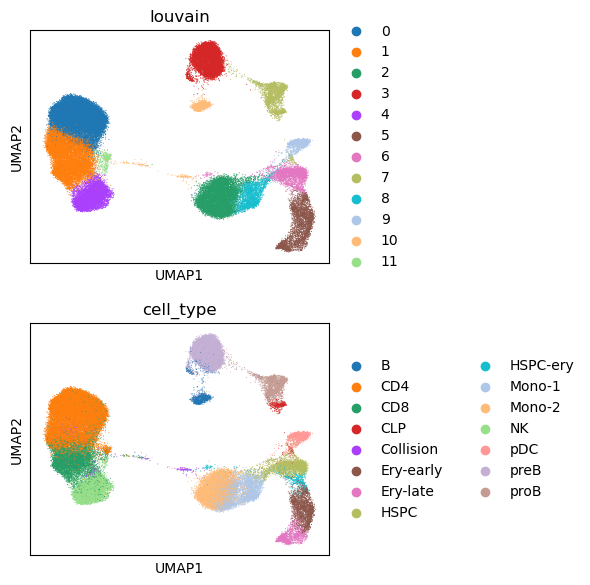

CPU times: user 2.89 s, sys: 278 ms, total: 3.16 s
Wall time: 1.04 s


In [14]:
%%time

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6), dpi=100)

sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.umap(adata, color=['cell_type'], ax=axs[1], show=False)

plt.tight_layout()
plt.show()

### tSNE visualization

In [15]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 44min 30s, sys: 3min 5s, total: 47min 36s
Wall time: 4min 6s


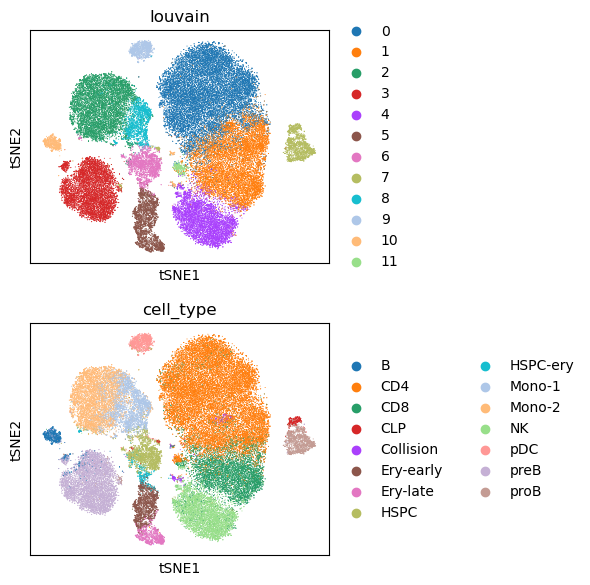

CPU times: user 5.23 s, sys: 554 ms, total: 5.78 s
Wall time: 1.1 s


In [16]:
%%time

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6), dpi=100)

sc.pl.tsne(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.tsne(adata, color=['cell_type'], ax=axs[1], show=False)

plt.tight_layout()
plt.show()

### Visualize marker gene activities

We use the raw adata object to compute gene activity scores. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [17]:
%%time
# find which peaks overlap with each marker gene (+ 5kb upstream)
peaks_per_gene = {gene : [] for gene in markers}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in markers:
        if utils.overlap(marker_coords[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")

MS4A1 has 2 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 558 ms, sys: 0 ns, total: 558 ms
Wall time: 556 ms


In [18]:
%%time
# Calculate per-cell gene activity scores for each marker gene
cell_gene_scores = np.zeros((adata.X.shape[0], len(marker_coords.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1) + 1

# Store per-cell gene activity scores with adata
for (i, gene) in enumerate(markers):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

CPU times: user 2.04 s, sys: 32 ms, total: 2.07 s
Wall time: 2.07 s


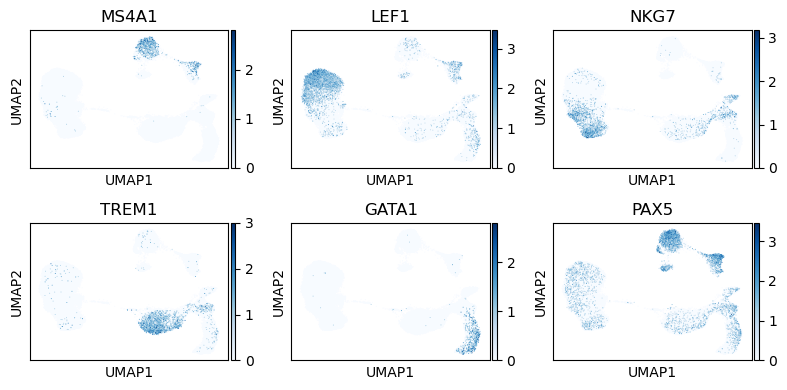

CPU times: user 5.85 s, sys: 547 ms, total: 6.39 s
Wall time: 1.93 s


In [19]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=100)
axs = axs.flatten()
for (i, gene) in enumerate(markers):
    sc.pl.umap(adata, color_map="Blues", color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

## Find differential peaks

We use a logistic regression model to find peaks that show differential activity across clusters. Here, we needed to increase the maximum number of iterations to 1000 for the model to converge. The maximum number of iterations is set to 1000 by default in the RAPIDS function.

In [20]:
%%time
sc.tl.rank_genes_groups(adata, 
                        groupby="louvain", 
                        n_genes=n_diff_peaks, 
                        groups='all', 
                        reference='rest',
                        method='logreg',
                        max_iter=1000
                       )

CPU times: user 2h 46min 59s, sys: 35min 59s, total: 3h 22min 59s
Wall time: 32min 4s


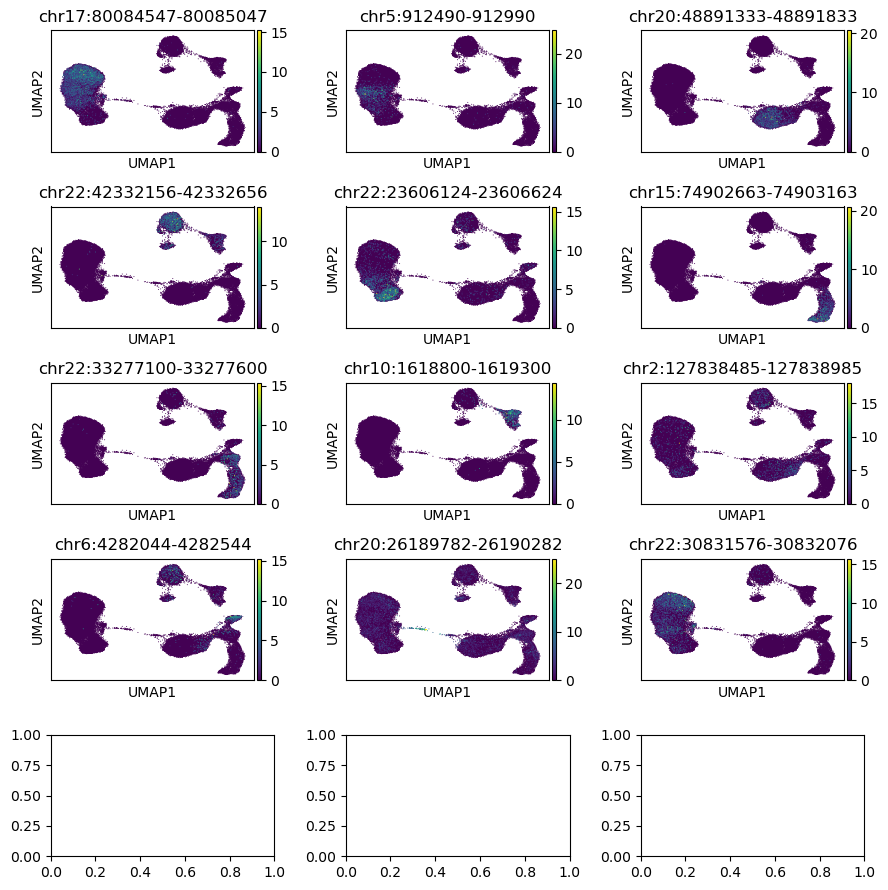

CPU times: user 9.06 s, sys: 359 ms, total: 9.42 s
Wall time: 6.65 s


In [21]:
%%time

fig, axs = plt.subplots(len(adata.uns['rank_genes_groups']['names'][0])//3 + 1, 3, figsize=(9,9), dpi=100)
axs = axs.flatten()

for (i, peak) in enumerate(adata.uns['rank_genes_groups']['names'][0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], show=False,
           vmax=min(25, np.max(adata[:,peak].X)),
           cmap='viridis'
          )
plt.tight_layout()
plt.show()

In [22]:
print("Full time: %s" % (time.time() - start_time))

Full time: 2713.325888156891
